In [61]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [23]:
input_path = os.path.join(".", "input")
target_col = "click"

df_train = pd.read_table(os.path.join(input_path, "train.tsv")).set_index("id")
df_test = pd.read_table(os.path.join(input_path, "test.tsv")).set_index("id")

In [3]:
X = df_train.drop([target_col], axis=1)
y = df_train[target_col]
X_test = df_test

In [4]:
df_train.head()

,click,I1,I2,C1,C2,C3,C4,C5,C6,I3,...,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14
id,,,,,,,,,,,,,,,,,,,,,
0,0,5,20,421256035,2377199148,2696211399,2298910535,3133252034,1509930964,1,...,0,0,0,0,0,0,NaN,NaN,NaN,780.0
1,0,5,20,2581703001,2589684548,1998340283,2411205997,3202148071,1238839469,0,...,1,1,0,0,0,0,NaN,NaN,NaN,0.0
2,0,5,20,2581703001,1862037199,2448089184,2411205997,1107442947,3668889797,2,...,0,0,0,0,1,0,NaN,NaN,NaN,117.0
3,0,5,20,421256035,3874378935,1658216424,2298910535,2321672976,1509930964,1,...,0,0,0,0,0,0,6.0,6.0,34501.0,390.0
4,1,5,20,421256035,3874378935,1892769125,2411205997,2321672976,1509930964,1,...,0,0,0,0,0,0,1.0,31.0,12557.0,390.0


In [5]:
df_test.head()

,I1,I2,C1,C2,C3,C4,C5,C6,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14
id,,,,,,,,,,,,,,,,,,,,
1169042,5,20,421256035,3874378935,1892769125,2411205997,2321672976,1509930964,1,0,0,0,0,0,0,0,1.0,35.0,76335.0,390.0
1169043,5,20,421256035,1537671376,575044823,2298910535,1301721902,3111151614,2,0,0,1,0,0,0,0,69.0,1.0,5634916.0,91.0
1169044,5,20,421256035,1392597759,2522517098,2298910535,2321672976,1509930964,2,0,0,0,0,0,0,0,NaN,NaN,NaN,1300.0
1169045,5,20,2581703001,1862037199,2448089184,2411205997,476085660,2068230268,1,1,0,0,0,0,0,1,NaN,NaN,NaN,52.0
1169046,5,20,421256035,3874378935,1892769125,2411205997,2321672976,1509930964,1,0,0,0,0,0,0,0,6.0,1.0,3921.0,390.0


In [6]:
df_train[target_col].value_counts()

0    1081295
1      87747
Name: click, dtype: int64

<BarContainer object of 2 artists>

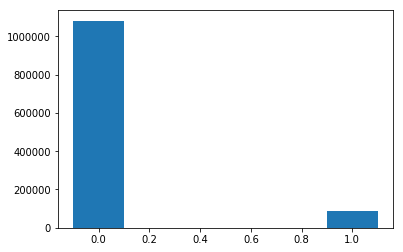

In [7]:
dict_target = dict(df_train[target_col].value_counts())
plt.bar(dict_target.keys(), dict_target.values(), width=0.2)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169042 entries, 0 to 1169041
Data columns (total 21 columns):
click    1169042 non-null int64
I1       1169042 non-null int64
I2       1169042 non-null int64
C1       1169042 non-null int64
C2       1169042 non-null int64
C3       1169042 non-null int64
C4       1169042 non-null int64
C5       1169042 non-null int64
C6       1169042 non-null int64
I3       1169042 non-null int64
I4       1169042 non-null int64
I5       1169042 non-null int64
I6       1169042 non-null int64
I7       1169042 non-null int64
I8       1169042 non-null int64
I9       1169042 non-null int64
I10      1169042 non-null int64
I11      981754 non-null float64
I12      981754 non-null float64
I13      981754 non-null float64
I14      1129422 non-null float64
dtypes: float64(4), int64(17)
memory usage: 196.2 MB


数値以外の型がない為、ダミー化は必要なさそう

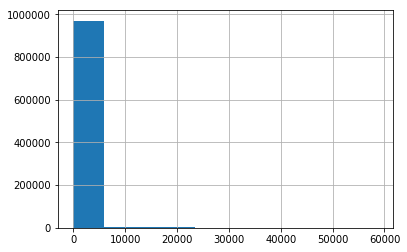

In [119]:
df_train["I11"].hist()

正規分布に見えないので、とりあえず欠損値は中央値で補完する

In [120]:
from sklearn.impute import SimpleImputer

impute = SimpleImputer(strategy="median")

In [121]:
X_ = impute.fit_transform(X)
X_test_ = impute.transform(X_test)

とりあえず、XGBoostでそのまま交差検証

In [122]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [123]:
cv_scores = np.zeros(len(y))

In [124]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [125]:
for cnt, indx in enumerate(skf.split(X_, y)):
    X_train, y_train = X_[indx[0]], y[indx[0]]
    X_valid, y_valid = X_[indx[1]], y[indx[1]]
    clf = LGBMClassifier(device="gpu")
    clf.fit(X_train, y_train)
    cv_scores[indx[1]] += clf.predict_proba(X_valid)[:, 1]

In [126]:
from sklearn.metrics import log_loss

log_loss(y, cv_scores)

0.2105462708392794

SIGNSTEを見るとこのままでもランキング上位に入れるが、物足りない...

In [127]:
clf.fit(X_, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [128]:
os.makedirs(".\\outputs\\", exist_ok=True)

In [129]:
predict = clf.predict_proba(X_test_)[:, 1]
pd.DataFrame(predict, index=df_test.index).to_csv("./outputs/submit.csv", header=False)

Public Score : 0.19716

とりあえず標準化してみよう

In [130]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X__ = sc.fit_transform(X_)
X_test__ = sc.transform(X_test_)

In [131]:
sc_cv_scores = np.zeros(len(y))
for cnt, indx in enumerate(skf.split(X__, y)):
    X_train, y_train = X__[indx[0]], y[indx[0]]
    X_valid, y_valid = X__[indx[1]], y[indx[1]]
    clf = LGBMClassifier(device="gpu")
    clf.fit(X_train, y_train)
    sc_cv_scores[indx[1]] += clf.predict_proba(X_valid)[:, 1]

In [132]:
log_loss(y, sc_cv_scores)

0.21058528154348508

In [134]:
clf.fit(X__, y)
predict = clf.predict_proba(X_test__)[:, 1]
pd.DataFrame(predict, index=df_test.index).to_csv("./outputs/sc_submit.csv", header=False)

Public Score : 0.19698

あまり効果がない...

目的変数がアンバランスなことが問題?<br>
データ数が多いので、アンダーサンプリングしてみる

In [135]:
from imblearn.under_sampling import RandomUnderSampler
minor_count = df_train[target_col].value_counts()[1]
sampling = RandomUnderSampler(ratio={0: minor_count, 1: minor_ratio})
X_sampled, y_sampled = sampling.fit_sample(X_, y)

In [136]:
X_cols, y_cols = X.columns, [target_col]
df_sampled = pd.concat([pd.DataFrame(X_sampled, columns=X_cols), pd.DataFrame(y_sampled, columns=y_cols)], axis=1)
df_sampled[target_col].value_counts()

1    87747
0    87747
Name: click, dtype: int64

In [137]:
sampled_scores = np.zeros(len(df_sampled))
for indx in skf.split(X_sampled, y_sampled):
    X_train, y_train = X_sampled[indx[0]], y_sampled[indx[0]]
    X_valid, y_valid = X_sampled[indx[1]], y_sampled[indx[1]]
    clf.fit(X_train, y_train)
    sampled_scores[indx[1]] += clf.predict_proba(X_valid)[:, 1]

In [138]:
log_loss(y_sampled, sampled_scores)

0.5144001701760216

In [139]:
clf.fit(X_sampled, y_sampled)
predict = clf.predict_proba(X_test_)[:, 1]
pd.DataFrame(predict, index=df_test.index).to_csv("sampling_submit.csv", header=False)

Pubscore : 0.51360<br>
スコアが低い...サンプリングはやめよう...

Kaggleでもよく使用されているスタッキングを試してみる

In [141]:
est_lgb = LGBMClassifier(device="gpu")
est_xgb = XGBClassifier(device="gpu")

In [150]:
import joblib

lgb_cv_score = np.zeros(len(y))
xgb_cv_score = np.zeros(len(y))

os.makedirs(".\\lgb_models\\", exist_ok=True)
os.makedirs(".\\xgb_models\\", exist_ok=True)

for cnt, indx in enumerate(skf.split(X_, y)):
    print(cnt+1, "Fold")
    X_train, y_train = X_[indx[0]], y[indx[0]]
    X_valid, y_valid = X_[indx[1]], y[indx[1]]
    
    est_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    est_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    
    joblib.dump(est_lgb, "lgb_models\\{}Fold_lgb.model".format(cnt+1))
    joblib.dump(est_xgb, "xgb_models\\{}Fold_xgb.model".format(cnt+1))
    
    lgb_cv_score[indx[1]] += est_lgb.predict_proba(X_valid)[:, 1]
    xgb_cv_score[indx[1]] += est_xgb.predict_proba(X_valid)[:, 1]

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold


In [60]:
import gc
gc.enable()
gc.collect()

3380

In [160]:
print(log_loss(y, lgb_cv_score))
print(log_loss(y, xgb_cv_score))
print(log_loss(y, np.mean([lgb_cv_score, xgb_cv_score], axis=0)))

0.21054627748269553
0.21746797243447016
0.21293145607976668


In [152]:
lgb_models = os.listdir("./lgb_models/")
xgb_models = os.listdir("./xgb_models/")

In [154]:
lgb_predict = np.zeros(len(X_test_))
for model in lgb_models:
    clf = joblib.load("./lgb_models/" + model)
    lgb_predict += clf.predict_proba(X_test_)[:, 1]
lgb_predict /= len(lgb_models)

In [155]:
xgb_predict = np.zeros(len(X_test_))
for model in xgb_models:
    clf = joblib.load("./xgb_models/" + model)
    xgb_predict += clf.predict_proba(X_test_)[:, 1]
xgb_predict /= len(xgb_models)

In [165]:
mean_predict = np.mean([lgb_predict, xgb_predict], axis=0)

In [166]:
pd.DataFrame(lgb_predict, index=df_test.index).to_csv("./outputs/stacking_lgb.csv", header=False)
pd.DataFrame(xgb_predict, index=df_test.index).to_csv("./outputs/stacking_xgb.csv", header=False)
pd.DataFrame(mean_predict, index=df_test.index).to_csv("./outputs/stacking_mean.csv", header=False)

LightGBM : **0.19689**  
XGBoost  : 0.20185  
Mean     : 0.19868

XGBoostが足を引っ張ってる...  
-> LightGBMで頑張ろう

標準化も試してみる

In [167]:
import joblib

lgb_cv_score = np.zeros(len(y))
xgb_cv_score = np.zeros(len(y))

os.makedirs(".\\lgb_sc_models\\", exist_ok=True)
os.makedirs(".\\xgb_sc_models\\", exist_ok=True)

for cnt, indx in enumerate(skf.split(X__, y)):
    print(cnt+1, "Fold")
    X_train, y_train = X__[indx[0]], y[indx[0]]
    X_valid, y_valid = X__[indx[1]], y[indx[1]]
    
    est_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    est_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    
    joblib.dump(est_lgb, "lgb_sc_models\\{}Fold_lgb.model".format(cnt+1))
    joblib.dump(est_xgb, "xgb_sc_models\\{}Fold_xgb.model".format(cnt+1))
    
    lgb_cv_score[indx[1]] += est_lgb.predict_proba(X_valid)[:, 1]
    xgb_cv_score[indx[1]] += est_xgb.predict_proba(X_valid)[:, 1]

1 Fold
2 Fold
3 Fold
4 Fold
5 Fold


In [169]:
print(log_loss(y, lgb_cv_score))
print(log_loss(y, xgb_cv_score))
print(log_loss(y, np.mean([lgb_cv_score, xgb_cv_score], axis=0)))

0.21058543432450344
0.21746797307707724
0.2129538301551036


In [170]:
lgb_models = os.listdir("./lgb_sc_models/")
xgb_models = os.listdir("./xgb_sc_models/")

lgb_predict = np.zeros(len(X_test__))
for model in lgb_models:
    clf = joblib.load("./lgb_sc_models/" + model)
    lgb_predict += clf.predict_proba(X_test__)[:, 1]
lgb_predict /= len(lgb_models)

xgb_predict = np.zeros(len(X_test__))
for model in xgb_models:
    clf = joblib.load("./xgb_sc_models/" + model)
    xgb_predict += clf.predict_proba(X_test__)[:, 1]
xgb_predict /= len(xgb_models)

mean_predict = np.mean([lgb_predict, xgb_predict], axis=0)

In [171]:
pd.DataFrame(lgb_predict, index=df_test.index).to_csv("./outputs/stacking_sc_lgb.csv", header=False)
pd.DataFrame(xgb_predict, index=df_test.index).to_csv("./outputs/stacking_sc_xgb.csv", header=False)
pd.DataFrame(mean_predict, index=df_test.index).to_csv("./outputs/stacking_sc_mean.csv", header=False)

LightGBM : **0.19688**  
XGBoost : 0.20185

In [172]:
imputer = SimpleImputer(strategy="mean")
X_ = imputer.fit_transform(X)
X_test_ = imputer.transform(X_test)

In [174]:
import joblib

lgb_cv_score = np.zeros(len(y))
xgb_cv_score = np.zeros(len(y))

os.makedirs(".\\lgb_NaN_to_mean_models\\", exist_ok=True)
os.makedirs(".\\xgb_NaN_to_mean_models\\", exist_ok=True)

for cnt, indx in enumerate(skf.split(X_, y)):
    print(cnt+1, "Fold")
    X_train, y_train = X_[indx[0]], y[indx[0]]
    X_valid, y_valid = X_[indx[1]], y[indx[1]]
    
    print("LightGBM Fitting...")
    est_lgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    print("XGBoosting Fitting...")
    est_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0, early_stopping_rounds=100)
    
    joblib.dump(est_lgb, "lgb_NaN_to_mean_models\\{}Fold_lgb.model".format(cnt+1))
    joblib.dump(est_xgb, "xgb_NaN_to_mean_models\\{}Fold_xgb.model".format(cnt+1))
    
    lgb_cv_score[indx[1]] += est_lgb.predict_proba(X_valid)[:, 1]
    xgb_cv_score[indx[1]] += est_xgb.predict_proba(X_valid)[:, 1]

1 Fold
LightGBM Fitting...
XGBoosting Fitting...
2 Fold
LightGBM Fitting...
XGBoosting Fitting...
3 Fold
LightGBM Fitting...
XGBoosting Fitting...
4 Fold
LightGBM Fitting...
XGBoosting Fitting...
5 Fold
LightGBM Fitting...
XGBoosting Fitting...


In [177]:
print(log_loss(y, lgb_cv_score))
print(log_loss(y, xgb_cv_score))
print(log_loss(y, np.mean([lgb_cv_score, xgb_cv_score], axis=0)))

0.21022957979220902
0.21742775948915644
0.21271829106682733


In [179]:
lgb_models = os.listdir("./lgb_NaN_to_mean_models/")
xgb_models = os.listdir("./xgb_NaN_to_mean_models/")

lgb_predict = np.zeros(len(X_test_))
for model in lgb_models:
    clf = joblib.load("./lgb_NaN_to_mean_models/" + model)
    lgb_predict += clf.predict_proba(X_test_)[:, 1]
lgb_predict /= len(lgb_models)

xgb_predict = np.zeros(len(X_test_))
for model in xgb_models:
    clf = joblib.load("./xgb_NaN_to_mean_models/" + model)
    xgb_predict += clf.predict_proba(X_test_)[:, 1]
xgb_predict /= len(xgb_models)

mean_predict = np.mean([lgb_predict, xgb_predict], axis=0)

In [180]:
pd.DataFrame(lgb_predict, index=df_test.index).to_csv("./outputs/stacking_NaNtoMean_lgb.csv", header=False)
pd.DataFrame(xgb_predict, index=df_test.index).to_csv("./outputs/stacking_NaNtoMean_xgb.csv", header=False)
pd.DataFrame(mean_predict, index=df_test.index).to_csv("./outputs/stacking_NaNtoMean_mean.csv", header=False)

**サイトを見ると特徴変数がCxxの列は元々文字列との記載が!**

In [9]:
df_train["C1"].value_counts()

421256035     766892
2581703001    227591
3651044092     53902
2686811630     33122
2387281372     30345
2541535031     21625
1111213504     15559
1045405899     14878
2068315619      5128
Name: C1, dtype: int64

In [10]:
array = []
for i in range(6):
    array = np.append(array, df_train["C"+str(i+1)].value_counts().keys().tolist())

In [11]:
c_list = set(array)

In [12]:
len(c_list)

712

ダミー変数化するには数が多い

一定数以上含まれる変数のみにする

In [13]:
def over(df, col, threshold=500):
    string = "over{}".format(threshold)
    df[string] = (df[col] > threshold)
    df[string].replace({False: np.nan}, inplace=True)
    df.dropna(how="any", axis=0, inplace=True)
    return df.index.tolist()

In [14]:
threshold = len(df_train) * 0.1
array = []
for i in range(6):
    array = np.append(array, over(pd.DataFrame(df_train["C{}".format(i+1)].value_counts()), "C{}".format(i+1), threshold))

In [56]:
c_list = list(set(array))
c_list = [int(i) for i in c_list]

In [57]:
c_list

[2448089184,
 1332932160,
 421256035,
 2589684548,
 1892769125,
 1410458339,
 2298910535,
 3668889797,
 2411205997,
 1862037199,
 2321672976,
 1509930964,
 3874378935,
 2581703001,
 2068230268,
 3111151614]

In [58]:
for j in range(1, 7):
    for i in c_list:
        i = str(i)
        df_train["C{}_{}".format(j, i)] = df_train["C{}".format(j)].astype(str).str.contains(i)
        df_test["C{}_{}".format(j, i)] = df_test["C{}".format(j)].astype(str).str.contains(i)

In [59]:
df_train

,click,I1,I2,C1,C2,C3,C4,C5,C6,I3,...,C6_2298910535,C6_3668889797,C6_2411205997,C6_1862037199,C6_2321672976,C6_1509930964,C6_3874378935,C6_2581703001,C6_2068230268,C6_3111151614
id,,,,,,,,,,,,,,,,,,,,,
0,0,5,20,421256035,2377199148,2696211399,2298910535,3133252034,1509930964,1,...,False,False,False,False,False,True,False,False,False,False
1,0,5,20,2581703001,2589684548,1998340283,2411205997,3202148071,1238839469,0,...,False,False,False,False,False,False,False,False,False,False
2,0,5,20,2581703001,1862037199,2448089184,2411205997,1107442947,3668889797,2,...,False,True,False,False,False,False,False,False,False,False
3,0,5,20,421256035,3874378935,1658216424,2298910535,2321672976,1509930964,1,...,False,False,False,False,False,True,False,False,False,False
4,1,5,20,421256035,3874378935,1892769125,2411205997,2321672976,1509930964,1,...,False,False,False,False,False,True,False,False,False,False
5,0,5,20,421256035,1537671376,3788069208,2411205997,1410458339,3668889797,2,...,False,True,False,False,False,False,False,False,False,False
6,0,5,20,2581703001,1862037199,3950375036,1825710598,3351654386,3111151614,1,...,False,False,False,False,False,False,False,False,False,True
7,1,5,20,421256035,1537671376,3889790948,1332932160,1410458339,3668889797,2,...,False,True,False,False,False,False,False,False,False,False
8,0,5,20,421256035,1088910726,3862505502,2298910535,2321672976,1509930964,1,...,False,False,False,False,False,True,False,False,False,False


In [62]:
est = LGBMClassifier(device="gpu")

In [63]:
est.fit(df_train.drop(target_col, axis=1).values, df_train[target_col].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [75]:
predict = est.predict_proba(df_test.values)[:, 1]

In [76]:
pd.DataFrame(predict, index=df_test.index).to_csv("outputs/lgb_dummy_submit.csv", header=False)

Public score : 0.19658

C の削除

In [78]:
importance = dict(i for i in zip(df_test.columns, est.feature_importances_))

In [90]:
X_ = (df_train.drop(["C{}".format(i) for i in range(1, 7)], axis=1)).drop(target_col, axis=1)
y = df_train[target_col]
X_test = df_test.drop(["C{}".format(i) for i in range(1, 7)], axis=1)

In [91]:
est.fit(X_, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [92]:
importance_ = dict(i for i in zip(X_.columns, est.feature_importances_))

In [94]:
predict = est.predict_proba(X_test)[:, 1]
pd.DataFrame(predict, index=df_test.index).to_csv("outputs/lgb_dummy_drop_C_submit.csv", header=False)